In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from dataclasses import dataclass

In [2]:
@dataclass
class Result:
    train_losses: list[float]
    avg_train_accuracies: list[float]
    test_losses: list[float]
    test_accuracies: np.ndarray
    avg_test_accuracies: list[float]
    test_precision: np.ndarray
    test_recall: np.ndarray
    test_f1score: np.ndarray
    avg_test_precision: float
    avg_test_recall: float
    avg_test_f1score: float

In [7]:
CLASS_NAMES = []
with open("./name_of_the_animals.txt", "r") as file:
    for line in file:
        CLASS_NAMES.append(line.strip())

In [8]:
def print_basic_results(result: Result):
    print(f"Train Loss: {result.train_losses[-1]}")
    print(f"Train Accuracy: {result.avg_train_accuracies[-1] * 100}%\n")
    print(f"Test Loss: {result.test_losses[-1]}")
    print(f"Test Accuracy: {result.avg_test_accuracies[-1] * 100}%\n")
    print(f"Test Precision: {result.avg_test_precision * 100}%")
    print(f"Test Recall: {result.avg_test_recall * 100}%")
    print(f"Test F1 Score: {result.avg_test_f1score * 100}%")

In [90]:
def plot_loss_accuracy(result: Result) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    fig.subplots_adjust(wspace=0.4)

    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].plot(result.train_losses, label="Train Loss", color="blue")
    ax[0].plot(result.test_losses, label="Test Loss", color="red")
    ax[0].legend()
    ax[0].set_ylabel("Cross Entropy Loss")
    ax[0].grid(axis="both", linestyle="--", alpha=0.7)

    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].plot(np.array(result.avg_train_accuracies)*100, label="Train Accuracy", color="blue")
    ax[1].plot(np.array(result.avg_test_accuracies)*100, label="Test Accuracy", color="red")
    ax[1].legend()
    ax[1].set_ylabel("Accuracy (%)")
    ax[1].grid(axis="both", linestyle="--", alpha=0.7)

In [106]:
def plot_improvement_by_class(
    result_left: Result,
    result_right: Result,
    metric: str,
    classes: list[str],
    title: str = "Changes by Class",
    multiply_by: float = 1.0,
) -> None:
    # metric can be "test_accuracies", "test_precision", "test_recall", "test_f1score"
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

    diffs = np.array(result_right.__getattribute__(metric) - result_left.__getattribute__(metric))*multiply_by
    sorted_indices = np.argsort(diffs)
    diffs = diffs[sorted_indices]
    classes = np.array(classes)[sorted_indices]

    mask_positive = diffs >= 0
    mask_negative = diffs < 0

    negative = ax.bar(classes[mask_negative], diffs[mask_negative], color="red")
    ax.bar_label(negative, np.round(diffs[mask_negative], decimals=1), label_type="edge", rotation=90)
    
    positive = ax.bar(classes[mask_positive], diffs[mask_positive], color="green")
    ax.bar_label(positive, np.round(diffs[mask_positive], decimals=1), label_type="edge", rotation=90)

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel(f"Change in {metric.replace('_', ' ').title()}")

    diff_range = max(diffs) - min(diffs)
    ax.set_ylim(bottom=min(diffs) - 0.2*diff_range, top=max(diffs) + 0.2*diff_range)
    ax.axhline(0, color="black", lw=1, ls="-")

In [132]:
def plot_diff_barchart(results: dict[str, Result]) -> None:
    # bar chart showing performance in each desired metric for each group of results using the str key as a name
    metrics = {
        "Train Loss": {
            "key": "train_losses",
            "get_value": lambda x: x[-1],
        },
        "Train Accuracy (%)": {
            "key": "avg_train_accuracies",
            "get_value": lambda x: x[-1]*100.0,
        },
        "Test Loss": {
            "key": "test_losses",
            "get_value": lambda x: x[-1],
        },
        "Test Accuracy (%)": {
            "key": "avg_test_accuracies",
            "get_value": lambda x: x[-1]*100.0,
        },
        "Test Precision (%)": {
            "key": "avg_test_precision",
            "get_value": lambda x: x*100.0,
        },
        "Test Recall (%)": {
            "key": "avg_test_recall",
            "get_value": lambda x: x*100.0,
        },
        "Test F1 Score (%)": {
            "key": "avg_test_f1score",
            "get_value": lambda x: x*100.0,
        }
    }

    metric_names = list(metrics.keys())
    x = np.arange(len(metrics))
    total_width = 0.5
    width = total_width / len(results)
    offsets = np.linspace(-total_width/2, total_width/2, len(results))
    values = {}
    max_value = 0.0
    for result_name, result in results.items():
        for _, metric in metrics.items():
            if result_name not in values:
                values[result_name] = []
            value = metric["get_value"](result.__getattribute__(metric["key"]))
            values[result_name].append(value)
            if value > max_value:
                max_value = value

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
    for i, result_name in enumerate(values):
        bars = ax.bar(x + offsets[i], values[result_name], width, label=result_name)
        ax.bar_label(bars, np.round(values[result_name], decimals=1), label_type="edge", rotation=90)

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title("Comparison of Results by Metric")
    ax.set_xlabel("Metric")
    ax.set_ylabel("Percent or Loss Depending on Metric")
    ax.set_xticks(x, metric_names)
    ax.legend()
    ax.set_ylim(bottom=0, top=max_value + 0.2*max_value)

In [113]:
model_params = {
    "name": "cnn_tune",
    "learning_rate": 0.0075,
    "weight_decay": 0.0001,
    "epochs": 50,
}
with open(f"./results/{model_params["name"]}_{model_params["epochs"]}e_{str(model_params["learning_rate"])[2:]}lr_{str(model_params["weight_decay"])[2:]}wd.pkl", "rb") as f:
    results_50 = pkl.load(f)

In [114]:
model_params2 = {
    "name": "cnn_tune",
    "learning_rate": 0.0075,
    "weight_decay": 0.0001,
    "epochs": 30,
}
with open(f"./results/{model_params2["name"]}_{model_params2["epochs"]}e_{str(model_params2["learning_rate"])[2:]}lr_{str(model_params2["weight_decay"])[2:]}wd.pkl", "rb") as f:
    results_30_0001 = pkl.load(f)

In [115]:
model_params3 = {
    "name": "cnn_tune",
    "learning_rate": 0.0075,
    "weight_decay": 0.0002,
    "epochs": 30,
}
with open(f"./results/{model_params3["name"]}_{model_params3["epochs"]}e_{str(model_params3["learning_rate"])[2:]}lr_{str(model_params3["weight_decay"])[2:]}wd.pkl", "rb") as f:
    results_30_0002 = pkl.load(f)

In [116]:
model_params3 = {
    "name": "cnn_tune",
    "learning_rate": 0.0075,
    "weight_decay": 0.0005,
    "epochs": 30,
}
with open(f"./results/{model_params3["name"]}_{model_params3["epochs"]}e_{str(model_params3["learning_rate"])[2:]}lr_{str(model_params3["weight_decay"])[2:]}wd.pkl", "rb") as f:
    results_30_0005 = pkl.load(f)

In [117]:
model_params3 = {
    "name": "cnn_tune",
    "learning_rate": 0.0075,
    "weight_decay": 0.001,
    "epochs": 30,
}
with open(f"./results/{model_params3["name"]}_{model_params3["epochs"]}e_{str(model_params3["learning_rate"])[2:]}lr_{str(model_params3["weight_decay"])[2:]}wd.pkl", "rb") as f:
    results_30_001 = pkl.load(f)

In [11]:
print_basic_results(results_50)

Train Loss: 2.360886494318644
Train Accuracy: 37.259259819984436%

Test Loss: 4.164076089859009
Test Accuracy: 14.851851761341095%

Test Precision: 18.885120749473572%
Test Recall: 14.851853251457214%
Test F1 Score: 14.83781486749649%


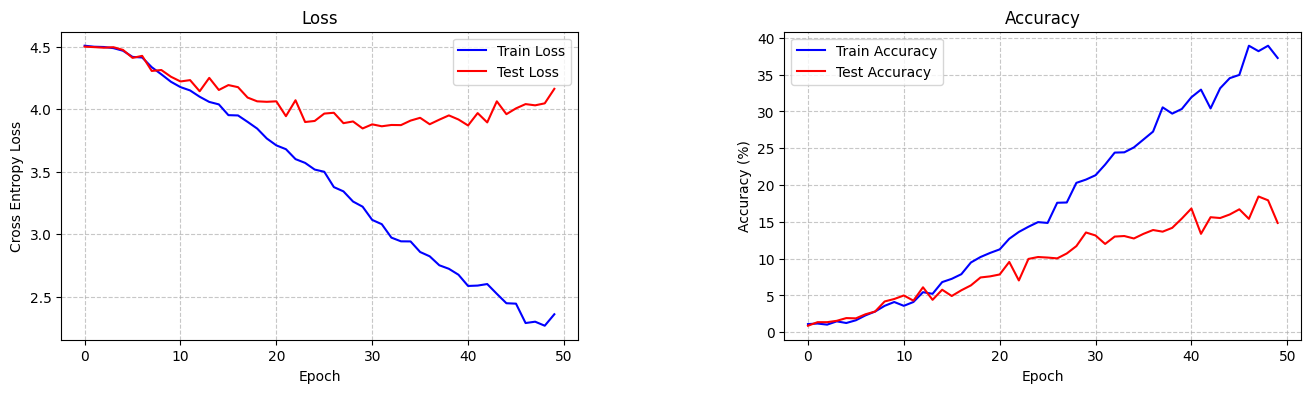

In [91]:
plot_loss_accuracy(results_50)

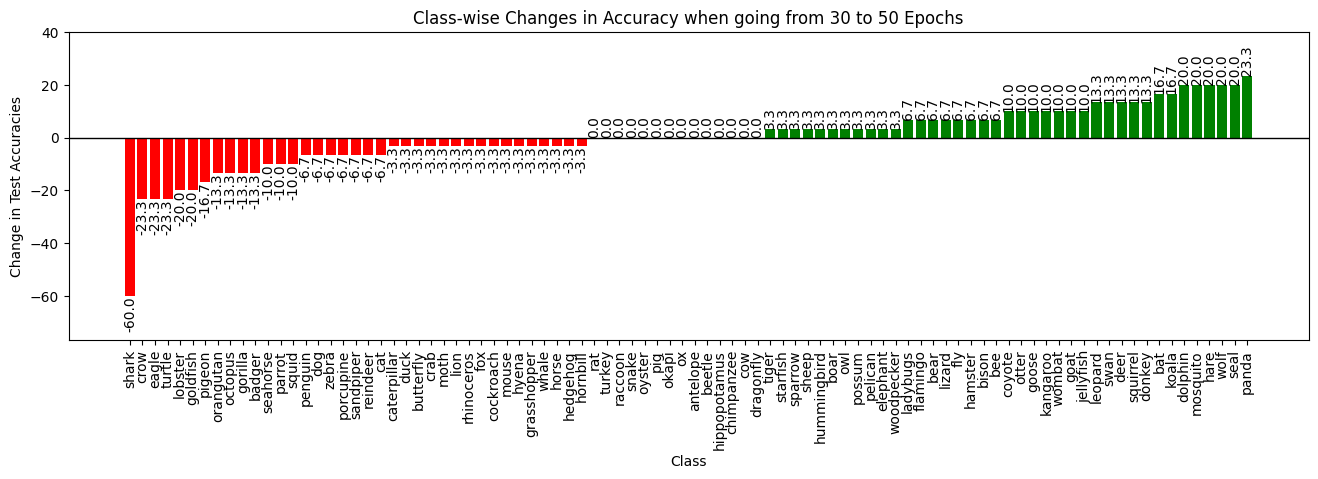

In [118]:
plot_improvement_by_class(results_30_0001, results_50, "test_accuracies", CLASS_NAMES, "Class-wise Changes in Accuracy when going from 30 to 50 Epochs", 100.0)

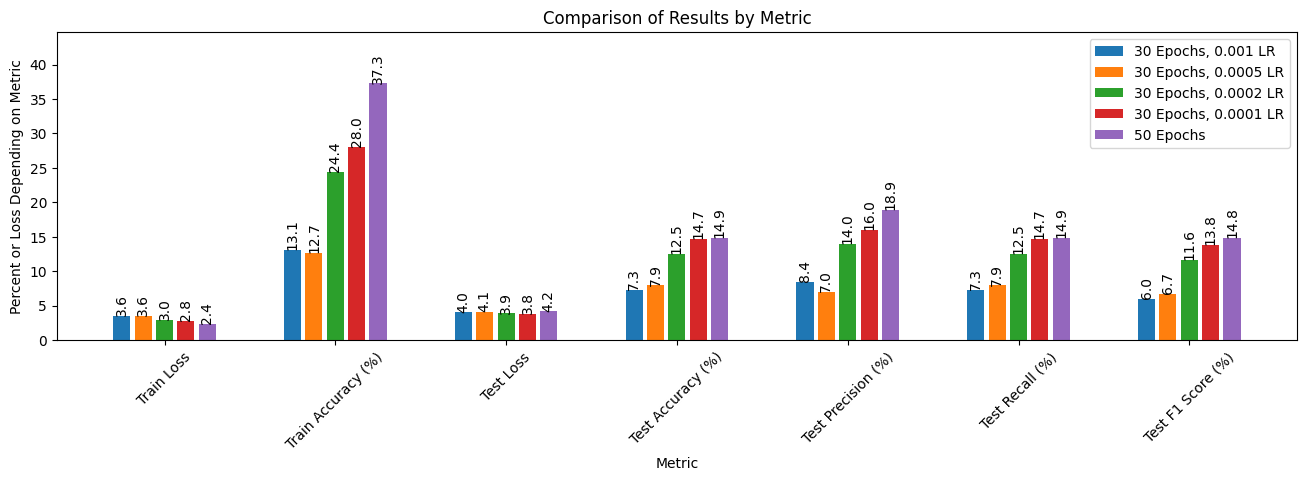

In [133]:
plot_diff_barchart({
    "30 Epochs, 0.001 LR": results_30_001,
    "30 Epochs, 0.0005 LR": results_30_0005,
    "30 Epochs, 0.0002 LR": results_30_0002,
    "30 Epochs, 0.0001 LR": results_30_0001,
    "50 Epochs": results_50,
})